#Data Preprocessing (Augmented)

In [3]:
import os
import warnings
import shutil

# Suppress warnings and TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

import kagglehub
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam



In [4]:
from sklearn.model_selection import train_test_split
import os
import shutil
import kagglehub

# Download dataset
base_path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")
print("Downloaded to:", base_path)

original_dir = base_path
output_dir = "dataset"

# Create output folders: Data_split/yes and Data_split/no
for category in ['yes', 'no']:
    category_path = os.path.join(original_dir, category)
    images = os.listdir(category_path)

    # Split images but do NOT separate them into train/test folders
    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)
    all_imgs = train_imgs + test_imgs  # combine both sets

    # Output path: e.g., Data_split/yes or Data_split/no
    category_output_path = os.path.join(output_dir, category)
    os.makedirs(category_output_path, exist_ok=True)

    # Copy all images to Data_split/yes or Data_split/no
    for img in all_imgs:
        src = os.path.join(category_path, img)
        dst = os.path.join(category_output_path, img)
        shutil.copy(src, dst)


Downloaded to: /kaggle/input/brain-mri-images-for-brain-tumor-detection


In [5]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# ===== CONFIGURATION =====
DATASET_DIR = '/content/dataset'        # Path to your dataset
TARGET_SIZE = (224, 224)                # Resize images to this size
AUG_PER_IMAGE = 3                       # Number of augmentations per image

# ===== AUGMENTATION GENERATOR =====
datagen = ImageDataGenerator(
    rotation_range=20,
    brightness_range=(0.8, 1.2),
    zoom_range=0.1,
    fill_mode='nearest'
)

# ===== PROCESS EACH CLASS =====
for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    print(f"Augmenting class: {class_name}")

    for fname in os.listdir(class_path):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(class_path, fname)
        img = load_img(img_path, target_size=TARGET_SIZE)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generate and save N augmented images
        i = 0
        for batch in datagen.flow(
            x,
            batch_size=1,
            save_to_dir=class_path,
            save_prefix=f'aug_{i}_{os.path.splitext(fname)[0]}',
            save_format='jpg'
        ):
            i += 1
            if i >= AUG_PER_IMAGE:
                break

print("✅ Augmentation complete. Augmented images saved.")


Augmenting class: yes
Augmenting class: no
✅ Augmentation complete. Augmented images saved.


In [6]:
import os

# Set your dataset path
DATASET_DIR = '/content/dataset'

# Count images per class
class_counts = {}

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    # Count valid image files
    image_count = len([
        f for f in os.listdir(class_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])

    class_counts[class_name] = image_count

# Print results
print("📊 Dataset Summary:")
total = 0
for cls, count in class_counts.items():
    print(f"📁 Class '{cls}': {count} images")
    total += count

print(f"\n✅ Total images in dataset: {total}")


📊 Dataset Summary:
📁 Class 'yes': 620 images
📁 Class 'no': 391 images

✅ Total images in dataset: 1011


In [7]:
augment_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    shear_range=0.2,
    rotation_range=30,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],     # Slight brightness variation
    fill_mode='nearest'
)


In [8]:
train_generator = augment_datagen.flow_from_directory(
    '/content/dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = augment_datagen.flow_from_directory(
    '/content/dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42
)


Found 809 images belonging to 2 classes.
Found 202 images belonging to 2 classes.


In [9]:
import os
import shutil
import random

# Set paths
original_dir = "/content/dataset"
output_dir = "/content/final_dataset"
categories = ['yes', 'no']

# Create directories
for split in ['train', 'val', 'test']:
    for category in categories:
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

# Split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Split the data
for category in categories:
    category_path = os.path.join(original_dir, category)
    images = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(images)

    total = len(images)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    train_imgs = images[:train_end]
    val_imgs = images[train_end:val_end]
    test_imgs = images[val_end:]

    # Move images
    for img in train_imgs:
        shutil.move(os.path.join(category_path, img), os.path.join(output_dir, 'train', category, img))
    for img in val_imgs:
        shutil.move(os.path.join(category_path, img), os.path.join(output_dir, 'val', category, img))
    for img in test_imgs:
        shutil.move(os.path.join(category_path, img), os.path.join(output_dir, 'test', category, img))

    print(f"{category}: {len(train_imgs)} train, {len(val_imgs)} val, {len(test_imgs)} test")


yes: 434 train, 124 val, 62 test
no: 273 train, 78 val, 40 test


#MobilNetV2 (Custom)


#Set parameter

In [10]:
img_size = 224  # MobileNetV2 default input size
batch_size = 32
num_classes = 2
train_dir = "/content/final_dataset/train"
val_dir = "/content/final_dataset/val"
test_dir = "/content/final_dataset/test"


#Data Generators

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 707 images belonging to 2 classes.
Found 202 images belonging to 2 classes.
Found 102 images belonging to 2 classes.


#Model

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),

    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),

    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        verbose=1,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_brain_tumor_model_improved_v3.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [15]:
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.5632 - loss: 0.7595
Epoch 1: val_accuracy improved from -inf to 0.67822, saving model to best_brain_tumor_model_improved_v3.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 789ms/step - accuracy: 0.5649 - loss: 0.7575 - val_accuracy: 0.6782 - val_loss: 0.5809 - learning_rate: 1.0000e-04
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.6890 - loss: 0.5796
Epoch 2: val_accuracy improved from 0.67822 to 0.79703, saving model to best_brain_tumor_model_improved_v3.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 352ms/step - accuracy: 0.6904 - loss: 0.5781 - val_accuracy: 0.7970 - val_loss: 0.4771 - learning_rate: 1.0000e-04
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.7244 - loss: 0.5278
Epoch 3: val_accuracy improved from 0.79703 to 0.84158, saving model to best_brain_tumor_model_improved_v3.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 395ms/step - accuracy: 0.7252 - loss: 0.5273 - val_accuracy: 0.8416 - val_loss: 0.4120 - learning_rate: 1.0000e-04
Epoch 4/30
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.7359 - loss: 0.4758
Epoch 4: val_accuracy improved from 0.84158 to 0.85644, saving model to best_brain_tumor_model_improved_v3.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 390ms/step - accuracy: 0.7394 - loss: 0.4740 - val_accuracy: 0.8564 - val_loss: 0.3716 - learning_rate: 1.0000e-04
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.7851 - loss: 0.4243
Epoch 5: val_accuracy improved from 0.85644 to 0.88119, saving model to best_brain_tumor_model_improved_v3.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step - accuracy: 0.7859 - loss: 0.4240 - val_accuracy: 0.8812 - val_loss: 0.3337 - learning_rate: 1.0000e-04
Epoch 6/30
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.8180 - loss: 0.3874
Epoch 6: val_accuracy did not improve from 0.88119
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 345ms/step - accuracy: 0.8200 - loss: 0.3859 - val_accuracy: 0.8812 - val_loss: 0.3133 - learning_rate: 1.0000e-04
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8464 - loss: 0.3677
Epoch 7: val_accuracy improved from 0.88119 to 0.89604, saving model to best_brain_tumor_model_improved_v3.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 390ms/step - accuracy: 0.8466 - loss: 0.3674 - val_accuracy: 0.8960 - val_loss: 0.2898 - learning_rate: 1.0000e-04
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.8461 - loss: 0.3532
Epoch 8: val_accuracy did not improve from 0.89604
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 378ms/step - accuracy: 0.8469 - loss: 0.3527 - val_accuracy: 0.8960 - val_loss: 0.2722 - learning_rate: 1.0000e-04
Epoch 9/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.8626 - loss: 0.3432
Epoch 9: val_accuracy did not improve from 0.89604
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - accuracy: 0.8623 - loss: 0.3434 - val_accuracy: 0.8960 - val_loss: 0.2672 - learning_rate: 1.0000e-04
Epoch 10/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8681 - loss: 0.3211
Epoch 10: val_accuracy improved from 0.89604 to 0.91584, saving model to best_brain_tumor_model_improved_v3.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 408ms/step - accuracy: 0.8683 - loss: 0.3214 - val_accuracy: 0.9158 - val_loss: 0.2411 - learning_rate: 1.0000e-04
Epoch 11/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8828 - loss: 0.3002
Epoch 11: val_accuracy improved from 0.91584 to 0.92079, saving model to best_brain_tumor_model_improved_v3.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 391ms/step - accuracy: 0.8822 - loss: 0.3003 - val_accuracy: 0.9208 - val_loss: 0.2307 - learning_rate: 1.0000e-04
Epoch 12/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.8801 - loss: 0.2937
Epoch 12: val_accuracy did not improve from 0.92079
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 334ms/step - accuracy: 0.8799 - loss: 0.2941 - val_accuracy: 0.9109 - val_loss: 0.2314 - learning_rate: 1.0000e-04
Epoch 13/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.8723 - loss: 0.2947
Epoch 13: val_accuracy did not improve from 0.92079
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 384ms/step - accuracy: 0.8723 - loss: 0.2953 - val_accuracy: 0.9158 - val_loss: 0.2147 - learning_rate: 1.0000e-04
Epoch 14/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9003 - loss: 0.2558
Epoch 14: val_accuracy did not improve from 0.92079
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 376ms/step - accuracy: 0.8996 - loss: 0.2564 - val_accuracy: 0.9109 - val_loss: 0.2147 - learning_rate: 1.0000e-04
Epo

23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 393ms/step - accuracy: 0.8789 - loss: 0.2749 - val_accuracy: 0.9257 - val_loss: 0.1982 - learning_rate: 1.0000e-04
Epoch 17/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.8939 - loss: 0.2443
Epoch 17: val_accuracy did not improve from 0.92574
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 380ms/step - accuracy: 0.8934 - loss: 0.2454 - val_accuracy: 0.9257 - val_loss: 0.1915 - learning_rate: 1.0000e-04
Epoch 18/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.8764 - loss: 0.2573
Epoch 18: val_accuracy did not improve from 0.92574
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 344ms/step - accuracy: 0.8766 - loss: 0.2578 - val_accuracy: 0.9257 - val_loss: 0.1897 - learning_rate: 1.0000e-04
Epoch 19/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9064 - loss: 0.2344
Epoch 19: val_accuracy improved from 0.92574 to 0.93069, saving model to best_brain_tumor_model_improved_v3.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 360ms/step - accuracy: 0.9056 - loss: 0.2350 - val_accuracy: 0.9307 - val_loss: 0.1910 - learning_rate: 1.0000e-04
Epoch 20/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8961 - loss: 0.2494
Epoch 20: val_accuracy did not improve from 0.93069
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 407ms/step - accuracy: 0.8967 - loss: 0.2489 - val_accuracy: 0.9208 - val_loss: 0.1779 - learning_rate: 1.0000e-04
Epoch 21/30
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8978 - loss: 0.2431
Epoch 21: val_accuracy did not improve from 0.93069
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 361ms/step - accuracy: 0.8977 - loss: 0.2437 - val_accuracy: 0.9307 - val_loss: 0.1733 - learning_rate: 1.0000e-04
Epoch 22/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9128 - loss: 0.2261
Epoch 22: val_accuracy improved from 0.93069 to 0.93564, saving model to best_brain_tumor_model_improved_v3.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 426ms/step - accuracy: 0.9129 - loss: 0.2263 - val_accuracy: 0.9356 - val_loss: 0.1671 - learning_rate: 1.0000e-04
Epoch 23/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9160 - loss: 0.2312
Epoch 23: val_accuracy improved from 0.93564 to 0.95050, saving model to best_brain_tumor_model_improved_v3.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 364ms/step - accuracy: 0.9156 - loss: 0.2316 - val_accuracy: 0.9505 - val_loss: 0.1637 - learning_rate: 1.0000e-04
Epoch 24/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.9029 - loss: 0.2310
Epoch 24: val_accuracy did not improve from 0.95050
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 378ms/step - accuracy: 0.9033 - loss: 0.2309 - val_accuracy: 0.9505 - val_loss: 0.1633 - learning_rate: 1.0000e-04
Epoch 25/30
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9041 - loss: 0.2220
Epoch 25: val_accuracy did not improve from 0.95050
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 374ms/step - accuracy: 0.9040 - loss: 0.2230 - val_accuracy: 0.9406 - val_loss: 0.1566 - learning_rate: 1.0000e-04
Epoch 26/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9022 - loss: 0.2572
Epoch 26: val_accuracy did not improve from 0.95050
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 345ms/step - accuracy: 0.9028 - loss: 0.2560 - val_accuracy: 0.9455 - val_loss: 0.1547 - learning_rate: 1.0000e-04
Epo

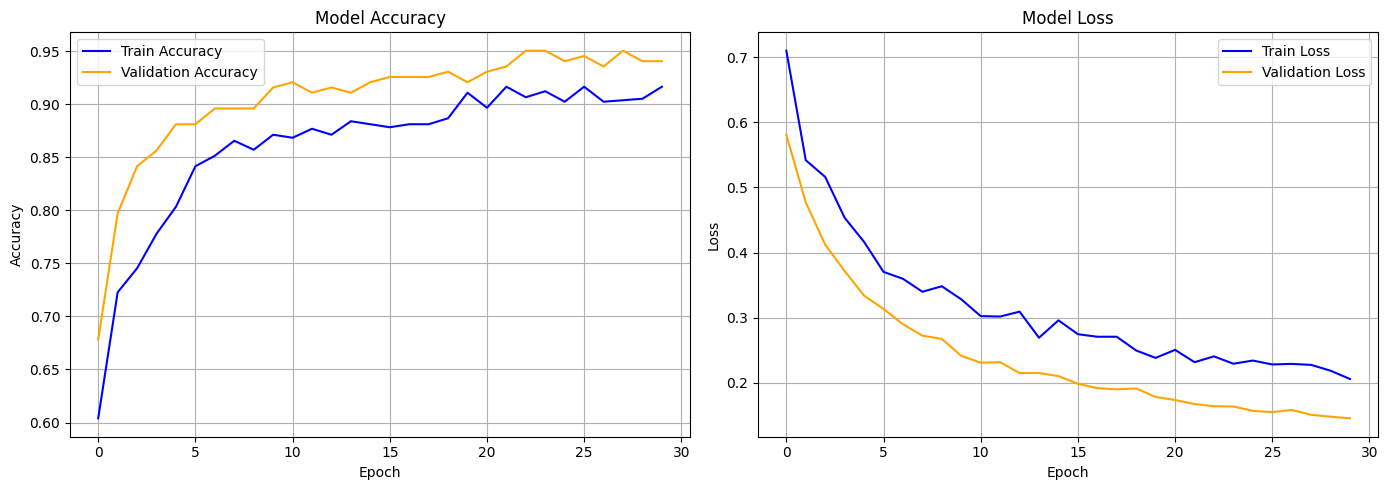

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axs[0].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Loss plot
axs[1].plot(history.history['loss'], label='Train Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='orange')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [17]:
y_pred_probs = model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_gen.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['No Tumor', 'Tumor']))

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.97      0.88      0.92        40
       Tumor       0.92      0.98      0.95        62

    accuracy                           0.94       102
   macro avg       0.95      0.93      0.94       102
weighted avg       0.94      0.94      0.94       102



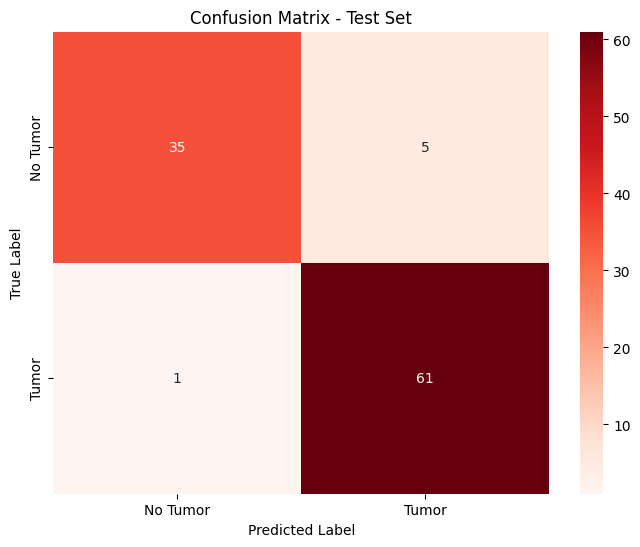

In [18]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

In [19]:
test_loss, test_accuracy = model.evaluate(test_gen, verbose=0)
print(f"\nFinal Test Results:")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Final Test Results:
Test Accuracy: 94.12%
Test Loss: 0.1736


In [21]:
model.save("brain_tumor_classifier_improved_v4.keras")